#### Streamlit App

For a demo of the final product, watch the [Loom](https://www.loom.com/share/629bb25a445f4bdbb2d6a839d5f1ce13) video here.

## Automatic Text Summarization

#### Methodology

In this notebook, we go through the different steps in building an extractive text summarizer. 

- First, we collect the data from zip files available through the [Newsroom](http://lil.nlp.cornell.edu/newsroom/index.html) website. These files have already been stored in a local folder. 


- Then, we do some simple cleaning to ensure that there are no missing values or duplicates. 


- Next, we prepare our sentences in two ways: 


    - We prepare a set of "ready" sentences, by doing a soft clean (eg. simple removal of line breaks). These are the sentences that will be sorted in the end. 
    - We prepare a set of "hard cleaned" sentences (getting just the words). These are the sentences we will use in the training process. 

    
- After that, we turn these hard cleaned sentences, which are just the words at this point, into numerical vectors. 



- The last part will depend on the extractive method used and will involve 3 steps:
    
    1. creating an intermediate representation of the sentences
    2. scoring the sentences based on their intermediate representation
    3. generating a summary comprising of a number of the ready sentences
    


## Load and Extract

As always, we will start by importing our main libraries. These have already been installed in our working environment.

In [4]:
# import main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

To load and unzip those json files from our local directory, we will also import the json and gzip libraries.

In [5]:
import json, gzip

Since we need to do the same thing for three files, we can create a function for it.

In [6]:
# function for loading in data
def load_data(path):
    #create a list to store each dictionary in
    data = []
    #unzip the files from the path specified load in the data line by line
    with gzip.open(path) as f:
        for ln in f:
            obj = json.loads(ln)
            data.append(obj)
    
    return data

Now, we can call the function on the files we want.

In [7]:
# load in the training set
data_train = load_data("data/train.jsonl.gz")

In [8]:
# load in the validation set
data_valid = load_data("data/dev.jsonl.gz")

In [9]:
# check what the data looks like
data_train[5]

{'url': 'http://www.nydailynews.com/archives/news/2001/03/22/2001-03-22_joy_for_addicts_on_mend_as_c.html',
 'archive': 'http://web.archive.org/web/20080520122148id_/http://www.nydailynews.com:80/archives/news/2001/03/22/2001-03-22_joy_for_addicts_on_mend_as_c.html',
 'title': 'JOY FOR ADDICTS ON MEND AS CHILDREN ARE RETURNED',
 'date': '20080520122148',
 'text': 'All day, every day, Cheryl Bernstein thanks her 16-month-old son.\n\n"I gave life to Reid, but he gave me life - a reason to get clean and go on," she said yesterday after graduating from the Manhattan Family Treatment Court program.\n\nBernstein, 41, and her husband, Doug Flaumenbaum, 33, both recovering crack and heroin addicts, were among three dozen men and women who regained custody of their children. They are the third such group to graduate since the program\'s inauguration in 1998.\n\nThe court program directs drug-addicted parents to treatment and subjects them to frequent, consistent monitoring so parents can regain

We can work directly with the json data, but putting them into dataframes will make things a little more organized. It will also be easier to clean. We will extract three items: the text, the summary, and the title.

In [10]:
# create a function for making the dataframes
def make_df(data, size):
    
    # get the text, summary, and title for each document up to the specified size
    text = [data[i]['text'] for i in range(size)]
    
    summary = [data[i]['summary'] for i in range(size)]
    
    title = [data[i]['title'] for i in range(size)]
    
    # combine the columns
    df = pd.DataFrame({'text':text,'summary':summary, 'title':title})
    
    return df

We also set a size parameter so that we can easily change it later on. We now call our function on the three dictionaries to put them into dataframes. Only 1000 documents from the training set will be used initially. Once everything works, we come back here and start scaling up the data towards the end. We end up using 10000.

In [11]:
# create the train dataframe
df_train = make_df(data_train, 10000)

In [12]:
# create the validation dataframe
df_valid = make_df(data_valid, 3000)

## Data Cleaning

Here, we do some very simple cleaning of the data. Given this is a benchmark dataset, we expect it to be fairly clean.

In [13]:
# check the shape of the training set
df_train.shape

(10000, 3)

In [14]:
# check for missing values
df_train.isna().sum()/df_train.shape[0]*100

text       0.0
summary    0.0
title      0.0
dtype: float64

In [15]:
# check for duplicates
df_train.duplicated().sum()

0

In [16]:
# check the shape of the validation set
df_valid.shape

(3000, 3)

In [17]:
# check for missing values
df_valid.isna().sum()/df_valid.shape[0]

text       0.0
summary    0.0
title      0.0
dtype: float64

In [18]:
# check for duplicates
df_valid.duplicated().sum()

0

We have a clean dataset. Now let's do some text preprocessing.

## Sentence Tokenization

Let's first split up each document into sentences. Note that we will be using the "apply" method alot throughout this notebook since we are "apply"ing the same functions to each document.

In [19]:
# import libraries for text preprocessing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gilbertwong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# apply sentence tokenization to each document
train_text = df_train['text'].apply(sent_tokenize)
train_summary = df_train['summary'].apply(sent_tokenize)
valid_text = df_valid['text'].apply(sent_tokenize)
valid_summary = df_valid['summary'].apply(sent_tokenize)

In [21]:
# grab the titles as well
train_title = df_train['title']
valid_title = df_valid['title']

If we take a look at the resulting documents, we see that they have been segmented into sentences using the sent_tokenize method. They might not be entirely perfect but they will do for now.

## Soft Clean

Now we will do a soft clean of the sentences, meaning we clean them up so that they are presentable. These are the set of sentences that will be selected from to go into the final summary (we can't use fully cleaned sentences as they are just the words).

In [22]:
# import library for regular expressions
import re

We see in this article that there are line breaks and incorrectly encoded characters, so we can go ahead and remove those. We have also made the decision to remove anything inside brackets as they are often not important. 

In [23]:
# create the soft cleaner function
def s_cleaner(text): 
    # remove line breaks
    new_string = re.sub("\n", " ", text) 
    # remove hyphen encodings
    new_string = re.sub("Â\xad", "",new_string)
    # remove bracketed text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    
    return new_string

In [24]:
# create the ready functionn which applies the soft cleaner function
def ready(text):
    # create an empty list for storing the cleaned document
    cleaned = []
    # loop through each sentence and clean
    for x in text:
        cleaned.append(s_cleaner(x))
        
    return cleaned

In [25]:
# get the ready text
train_text_ready = train_text.apply(ready)
valid_text_ready = valid_text.apply(ready)

Again, we follow the same procedure of checking the documents to ensure that they have been properly cleaned.

In [26]:
# take a look at the ready text
train_text_ready[9]

["Wednesday, May 18th 2005, 9:59AM  Summer is shaping up as extra sweet at Cafe Centro, where the menu features treats like s'mores, chocolate fondue and a unique cocktail called the Cotton Candy Cosmo.",
 'The drink was created by mixologist Bill Rogers, whose inspiration was the fluffy confection that the restaurant  occasionally serves to customers.',
 'Priced at $9, the deeply colorful libation is topped with billows of bright pink cotton candy.',
 "It's light, summery and wonderful for sipping outside.",
 '2 ounces Absolut Citron Vodka  Pink cotton candy for the top  Shake vodka, Triple Sec, lime juice and cranberry juice vigorously in a shaker with ice.',
 'Strain into a martini glass.',
 'Garnish with pink cotton candy all around the rim and serve.']

## Hard Clean

Here, we clean the sentences again, this time, with the intention of getting just the words so that we can create numerical vectors out of them. The different preprocessing techniques used are as follows:

1. turn everything to lowercase - words starting a sentence should not be treated differently from words later on
2. remove anything inside brackets - often not important to the document
3. remove possessives - not needed to capture context of a sentence
4. remove special characters - not text data
4. remove stopwords - not needed to capture context of a sentence

First, we import the stopwords from the nltk library.

In [27]:
# import more libraries for text preprocessing
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gilbertwong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# download the stopwords
stop_words = stopwords.words('english')

Now for contractions, we can use the pycontraction library, but since it uses a pretrained model to determine the correct conversion, it can be quite slow, especially if we are dealing with a large amount of text data. A decision is made to instead manually map the contractions. An argument can also be made that articles which can often be quite formal do not use many contractions anyways.

In [29]:
# define contractions mappings manually
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", 
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  
                       "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                       "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", 
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have"}

Now, we put all of the preprocessing steps into a single function to be applied over all documents

In [30]:
# create the hard cleaner function
def h_cleaner(text):
    # convert to lowercase
    new_string = text.lower()
    # remove bracketed text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    # remove quotation marks
    new_string = re.sub('"','', new_string)
    # convert contractions
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")]) 
    # convert possessive nouns
    new_string = re.sub(r"'s\b","",new_string)
    # remove special characters and punctuations
    new_string = re.sub("[^a-zA-Z]", " ", new_string) 
    # keep everything but stopwords
    new_string = [w for w in new_string.split() if not w in stop_words]
    # get the cleaned text
    new_string = " ".join(new_string)
    
    return new_string

In [31]:
# create the function that applies the hard cleaner
def clean(text):
    # create an empty list for storing the hard cleaned documents
    cleaned = []
    # loop through the sentences and clean them
    for y in text:
       
        cleaned.append(h_cleaner(y))
        
    return cleaned

We apply the function to the train and validation sets for both text and summary. We will also apply the function to the titles as well. This will be necessary for one of our extractive methods.

In [32]:
# apply cleaing to each document
train_text_cleaned = train_text.apply(clean)
valid_text_cleaned = valid_text.apply(clean)
train_summary_cleaned = train_summary.apply(clean)
valid_summary_cleamed = valid_summary.apply(clean)

In [33]:
# clean the titles as well
train_title_cleaned = clean(train_title)
valid_title_cleaned = clean(valid_title)

Taking a look at the transformed text, we see that it has been cleaned quite well. 

In [34]:
# take a look at the cleaned text
train_text_cleaned[9]

['wednesday may th summer shaping extra sweet cafe centro menu features treats like mores chocolate fondue unique cocktail called cotton candy cosmo',
 'drink created mixologist bill rogers whose inspiration fluffy confection restaurant occasionally serves customers',
 'priced deeply colorful libation topped billows bright pink cotton candy',
 'light summery wonderful sipping outside',
 'ounces absolut citron vodka pink cotton candy top shake vodka triple sec lime juice cranberry juice vigorously shaker ice',
 'strain martini glass',
 'garnish pink cotton candy around rim serve']

Note also that stemming and lemmatization has not been applied. The reason for this is that they often fail to get the proper root word, cutting off parts of it. For example, converting of past tense words by removal of "ed" might turn a word like "red" into "r". The porterstemmer in nltk uses this suffix stripping algorithm. We can go with another algorithm to better stem the words but again, it may take long. Given the time that we have, we will leave it for now.


## EDA

Now that we have fully cleaned sentences, let's do some exploratory data analysis.

#### Word count

How many words do we have?

In [35]:
# list the words in each sentence of each document
text_word_count = pd.Series([i for y in train_text_cleaned for x in y for i in x.split()])

In [36]:
# print the length of the above list
print("Text word count: ", len(text_word_count))

Text word count:  3142274


In [37]:
# list the words in each sentence of each document
summary_word_count = pd.Series([i for y in train_summary_cleaned for x in y for i in x.split()])

In [38]:
# print the length of the above list
print("Summary word count: ", len(summary_word_count))

Summary word count:  205238


#### Vocab size

Looking at the vocabulary size, we can also see how big our document-term matrix might be.

In [39]:
# get the unique words from the list above 
text_vocab_size = text_word_count.nunique()

In [40]:
# print the unique word count
print("Text vocab size: ", text_vocab_size)

Text vocab size:  99100


In [41]:
# get the unique words
summary_vocab_size = summary_word_count.nunique()

In [42]:
# print the unique word count
print("Summary vocab size: ", summary_vocab_size)

Summary vocab size:  28529


#### Sentence Lengths

We should also look at the lengths of the sentences and articles to see what we are working with.

In [43]:
# list number of words for each sentence of each article
text_sentence_lengths = [len(x.split()) for y in train_text_cleaned for x in y]
# list number of sentences for each article
text_article_lengths = [len(y) for y in train_text_cleaned]
# list number of words for each sentence of each summary
summary_sentence_lengths = [len(x.split()) for y in train_summary_cleaned for x in y]
# list number of sentences for each summary
summary_article_lengths = [len(y) for y in train_summary_cleaned]

Since we are going to be converting our sentences into numerical vectors, specifically GloVe, we might want to know the length of the sentences.

Max text sentence length:  636


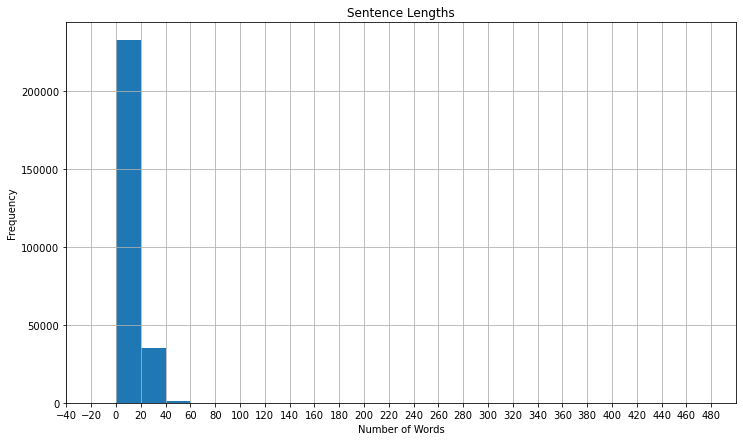

In [44]:
# look at distribution of sentence lengths for articles
print("Max text sentence length: ", max(text_sentence_lengths))

plt.figure(figsize=(12,7))
plt.hist(text_sentence_lengths, bins=range(-40,500,20))
plt.grid()
plt.title('Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(-40,500,20))
plt.xlim(-40,500)
plt.show()

Max summary sentence lenth:  84


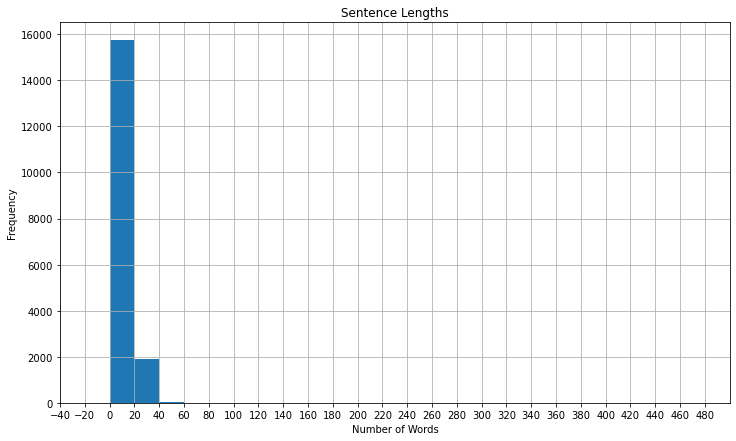

In [45]:
# look at distribution of sentence lengths for summaries
print("Max summary sentence lenth: ", max(summary_sentence_lengths))

plt.figure(figsize=(12,7))
plt.hist(summary_sentence_lengths, bins=range(-40,500,20))
plt.grid()
plt.title('Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xticks(range(-40,500,20))
plt.xlim(-40,500)
plt.show()

There seems to be some sentences that are quite long. To get sentence vectors rather than word vectors, we will need to average the many word vectors in a sentence to arrive at a consolidated sentence vector. For long sentences, this averaging process may blur out some of the context contained in the word vectors. However, since there are few, it should be okay. The only problem is that some extractive methods may tend to recognize longer sentences as more important. 

#### Article Lengths

Now the article lengths.

Max text article lenth:  1663


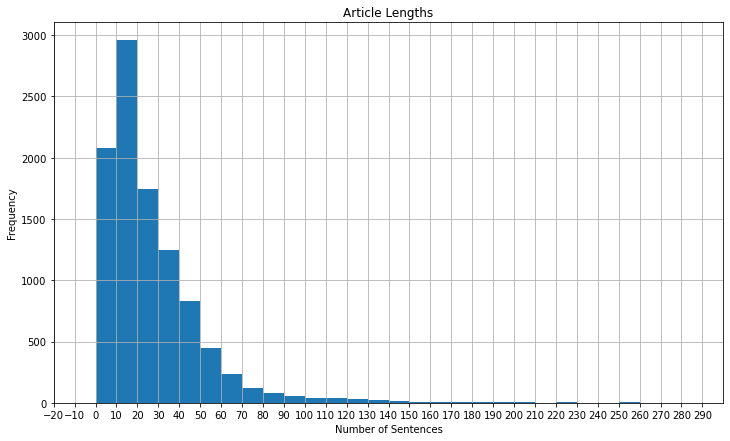

In [46]:
# look at distribution of article lengths
print("Max text article lenth: ", max(text_article_lengths))

plt.figure(figsize=(12,7))
plt.hist(text_article_lengths, bins=range(-30,300,10))
plt.grid()
plt.title('Article Lengths')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.xticks(range(-30,300,10))
plt.xlim(-20,300)
plt.savefig('article_lengths.png')
plt.show()

Max summary article lenth:  49


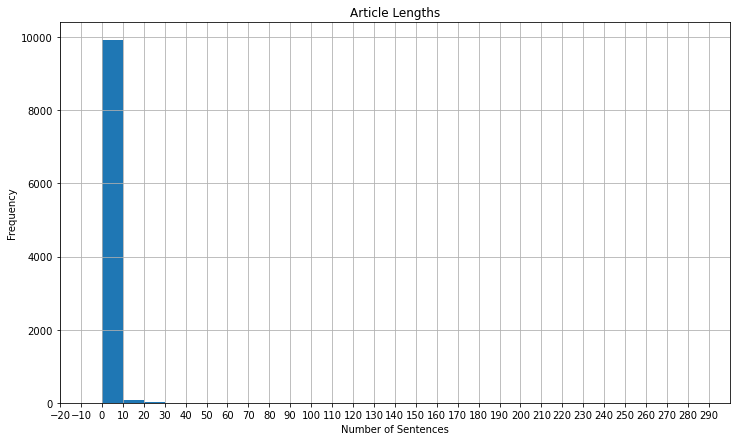

In [47]:
# look at distribution of summary lengths
print("Max summary article lenth: ", max(summary_article_lengths))

plt.figure(figsize=(12,7))
plt.hist(summary_article_lengths, bins=range(-30,300,10))
plt.grid()
plt.title('Article Lengths')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.xticks(range(-30,300,10))
plt.xlim(-20,300)
plt.show()

As we can see, most are the summaries are under 10 sentences and most of the articles are at most 40-50 sentences long. So let's try to get it down to no more than 5 sentences.

## GloVe Vectors

To represent our sentences numerically, we will be using Global Vectors which is an unsupervised algorithm for obtaining vector representations of words. It maps the words into a data space such that the distances between them represent their semantic similarity. We will be using the 100 dimensional glove vectors.

In [48]:
# store word vectors in a dictionary
word_embeddings = {}
with open('glove/glove.6B.100d.txt') as f:
    # for each line, get the word vector
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        word_embeddings[word] = coefs
# print number of word vectors found
print("Found %s word vectors." % len(word_embeddings))

Found 400000 word vectors.


We see that there are 400000 word vectors. This means that we have 100 dimensional vector representations for 400000 words which we can use for our text. Given our vocabulary size, these vectors should be able to represent most of the words we have. Let's get those word vectors now by searching through the text file and finding each associated vector.

In [49]:
# create the vectorizer
def glove(cleaned_text):
    # create an empty list to store each sentence vector of a document
    glove_vectors = []
    
    #for each sentence.. 
    for i in cleaned_text:
        if len(i)!=0:
            # get the associated vector
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            # zeros if for some reason the sentence is blank
            v = np.zeros((100,))
         # add vector to list
        glove_vectors.append(v)
        
    return glove_vectors

In [50]:
# vectorize each sentence of each document
train_text_vectors = train_text_cleaned.apply(glove)
valid_text_vectors = valid_text_cleaned.apply(glove)

In [51]:
# vectorize titles as well
train_title_vectors = glove(train_title_cleaned)
valid_title_vectors = glove(valid_title_cleaned)

To reiterate, for this document here, we have 7 sentences vectors of dimension 100. They were obtained by averaging the word vectors in each of the sentences.

In [52]:
# look at a vectorized document
pd.DataFrame(train_text_vectors[9])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.145162,0.202959,0.083033,0.021230,-0.033726,0.198228,0.224571,0.193912,-0.045268,-0.011951,...,0.032656,0.184367,-0.077485,-0.032076,-0.364801,-0.281641,-0.161108,-0.346176,0.400666,0.268685
1,-0.018886,0.056442,0.105896,-0.121437,0.249938,0.366046,0.167245,0.024463,-0.021834,-0.211786,...,0.178190,-0.047212,-0.011647,-0.212827,-0.253060,-0.015436,-0.244677,-0.224914,0.368187,0.262787
2,-0.304682,0.560569,-0.133618,-0.257897,0.302464,0.191935,0.084825,-0.016538,-0.121428,0.049960,...,0.135895,-0.081658,-0.311363,-0.389332,-0.444412,-0.221148,-0.655751,-0.070875,0.089192,0.142695
3,-0.148289,0.323313,0.200786,0.014595,0.025815,0.421324,0.159114,0.456669,-0.332641,-0.008107,...,0.536184,-0.158985,0.050224,-0.169998,-0.487363,0.020060,-0.381197,-0.140389,0.276157,0.587678
4,-0.213823,0.164425,-0.102897,-0.089077,0.103905,0.117737,0.626889,0.121240,0.051505,-0.035561,...,-0.152732,-0.009803,-0.775340,-0.392679,-0.234391,-0.532439,-0.216811,0.038757,0.312363,0.268043
5,-0.518291,0.554073,-0.363555,-0.063451,-0.698697,0.648744,0.559364,-0.252194,0.173947,-0.080063,...,0.095418,-0.328108,-0.080330,-0.137200,0.268265,0.047275,0.045918,-0.758071,-0.007365,-0.101419
6,-0.480881,0.312878,-0.030897,0.085693,0.261603,0.316802,0.157372,0.253171,-0.095553,-0.312359,...,-0.015550,-0.020629,-0.332199,-0.641851,-0.404755,-0.325123,-0.219310,-0.027603,0.497640,0.364649


Now that we have a numerical representation of our text data and have captured the semantics behind them, we can finally create an intermediate representation, meaning apply our extractive methods in such a way that we can rank our sentences in terms of importance. Let's start with TextRank.

## TextRank

The TextRank algorithm is basically just PageRank (an algorithm Google has used to rank its webpages) on text data. PageRank requires an adjacency matrix so in our case, we can use the similarity matrices to represent the connections between the sentences. We can then feed them to the pagerank algorithm which assign the sentences "pagerank scores" that tell us how important they are. Let's import cosine_similarity and networkx which is a library commonly used for network analysis. Let's also install and import rouge, the evaluation metric that we will be using to compare the generated summaries with the reference summaries.

In [53]:
# import required libraries
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from rouge import Rouge

#### Cosine Similarity

First off, we need to instantiate similarity matrices for each document. We can do this by creating a list and appending an empty matrix of size n (n = number of sentences) for each document. For 10000 documents, we should have 10000 matrices.

In [54]:
# create empty matrices 
sim_mat=[]
for i in train_text_vectors:
    sim_mat.append(np.zeros([len(i), len(i)]))

Now, we go through each matrix and fill them in with cosine similarities.

In [55]:
start_time = time.time()

# loop through each document
i=-1
for z in train_text_vectors:
    i+=1
    
    # loop through each sentence
    for y in range(len(z)):
        for x in range(len(z)):
            # calculate cosine similarity between each sentence and each other sentence in the document
            if y!=x:
                sim_mat[i][y][x] = cosine_similarity(z[y].reshape(1,100), z[x].reshape(1,100))[0,0]
                
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 71.41486599842708 minutes ---


Let's take a look at how one of them looks like.

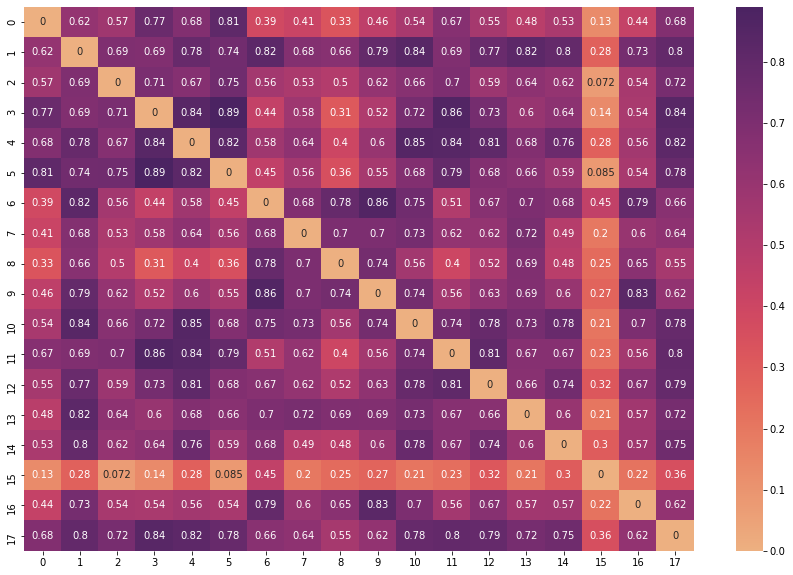

In [56]:
# plot a similarity matrix
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(sim_mat[4]),cmap='flare',annot=True)
plt.savefig('heatmap.png')

In [57]:
# look at associated sentences
train_text_ready[4][13:18]

['Bake for 25- 30 minutes or until golden brown.',
 'Look for phyllo dough in the supermarket freezer case.',
 'Once thawed, it can successfully be refrozen.',
 'Optional flavorings for the filling include a grating of fresh nutmeg and some chopped fresh dill.',
 'You can freeze spinach pie, well wrapped, for up to three months.']

Here we see that one of the sentences (middle) are different from the others. We see that its slightly shorter and has more rare words. Perhaps more rigorous stemming techniques should be explored later on.

#### PageRank Scores

Now that we have an intermediate represntation of the text, we can run the pagerank algorithm on each similarity matrix and score each sentence of each document.

In [58]:
# create an empty list for storing the scores
pagerank_scores=[]
# loop through matrices
for i in sim_mat:
    # run the page rank algorithm 
    nx_graph = nx.from_numpy_array(i)
    pagerank_scores.append(nx.pagerank_numpy(nx_graph))

If we take a look at the completed graph, we see that one of points is far away from the others. This is the sentence we saw before. That means TextRank was able to pick up on which sentences were less important. 

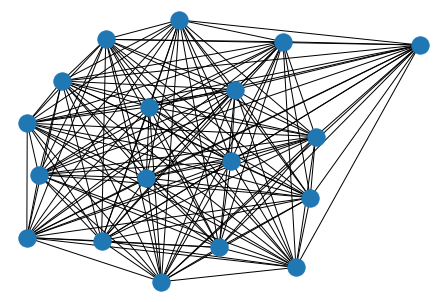

In [59]:
# look at a completed graph
nx.draw(nx.from_numpy_array(sim_mat[4]))

#### Ranking

Using the scores we got from the intermediate representation, let's rank the sentences accordingly.

In [60]:
# create a function to rank sentences based on scores
def rank(text, scores):
    # create an empty list for storing the scores
    ranked = []
    # rank and sort sentences for each document
    for x in range(len(text)):
        ranked_sentences = sorted(((scores[x][i],s) for i,s in enumerate(text[x])), reverse=True)
        ranked.append(ranked_sentences)
        
    return ranked

In [61]:
# apply ranking
textranked = rank(train_text_ready, pagerank_scores)

If we look at the top 3 sentences and the bottom 3 sentences, it is quite evident that TextRank did a good job at identifying important and non-important sentences.

In [62]:
# look at top ranked sentences
textranked[9][:3]

[(0.15483684211372117,
  "Wednesday, May 18th 2005, 9:59AM  Summer is shaping up as extra sweet at Cafe Centro, where the menu features treats like s'mores, chocolate fondue and a unique cocktail called the Cotton Candy Cosmo."),
 (0.1542837461531047,
  'Garnish with pink cotton candy all around the rim and serve.'),
 (0.14512804886305722,
  'Priced at $9, the deeply colorful libation is topped with billows of bright pink cotton candy.')]

In [63]:
# look at bottom ranked sentences
textranked[9][-3:]

[(0.1416671579793269,
  '2 ounces Absolut Citron Vodka  Pink cotton candy for the top  Shake vodka, Triple Sec, lime juice and cranberry juice vigorously in a shaker with ice.'),
 (0.13666039827631732,
  "It's light, summery and wonderful for sipping outside."),
 (0.12258655582655062, 'Strain into a martini glass.')]

#### Summary

Finally, we can generate the summary based on the above rankings. For articles longer than 5 sentences, we will create 5 sentence summaries. For articles less than 5 sentences, we will simply sort the sentences.

In [64]:
# create a function to extract a number of sentences
def summarize(ranked_sentences, length):
    # create a list for storing the sentences
    summaries = []
    
    # loop through each document
    for sentences in ranked_sentences:
        
        summary = ""
        # create summary of specified length
        if len(sentences)>length:
            for i in range(length):
                summary += sentences[i][1] + " "
        # if less than specified length, create summary of length document
        else:
            for i in range(len(sentences)):
                summary += sentences[i][1] + " "

        summaries.append(summary)
    
    return summaries

A function is used here so that we can easily change the length of summary later on.

In [65]:
# apply summarization
textrank_summaries = summarize(textranked, 5)

In [66]:
# look at a summary
textrank_summaries[9]

"Wednesday, May 18th 2005, 9:59AM  Summer is shaping up as extra sweet at Cafe Centro, where the menu features treats like s'mores, chocolate fondue and a unique cocktail called the Cotton Candy Cosmo. Garnish with pink cotton candy all around the rim and serve. Priced at $9, the deeply colorful libation is topped with billows of bright pink cotton candy. The drink was created by mixologist Bill Rogers, whose inspiration was the fluffy confection that the restaurant  occasionally serves to customers. 2 ounces Absolut Citron Vodka  Pink cotton candy for the top  Shake vodka, Triple Sec, lime juice and cranberry juice vigorously in a shaker with ice. "

Although the summary is not perfect, it is very usable. Note that the goal here is not to generate human-like summaries but ones adequate and reliable.

#### Evaluation

Let's also evaluate them against the reference summaries to see how they did. We use 2-gram overlaps for comparison which is more strict than a 1-gram. We also use the f1 score, which although not as interpretable as recall and precision individually, take into consideration both. If we use recall, we are looking at how much of the generated summary is in the reference summary. That means longer summaries will naturally have higher scores, making it not the best measure.

In [67]:
# create rouge evaluation function
def rouge2f(hypothesis,reference):
    
    rouge = Rouge()
    # create an empty list to store score of each summary
    scores = []
    
    # calculate rouge scores
    for i in range(len(hypothesis)): 
        score = rouge.get_scores(hypothesis[i], reference[i])[0]['rouge-2']['f']
        scores.append(score)
    
    return score

In [68]:
rouge2f(textrank_summaries,df_train['summary'])

0.5773195834371347

According to scientific literature, this score is considered very high. Advanced abstractive summarizers generally score around 40% so for an extractive approach like TextRank to score this high is really great.

## Latent Semantic Indexing

Now we move on to Latent Semantic Analysis, which is used for topic-modelling. By looking at the topics represented in the text and the "topic signatures" for each sentence, we can identify which sentences are more important. To perform singular value decomposition, we will use TruncatedSVD.

In [69]:
# import libraries
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

#### Topic Signatures

Now looping through each document, we perform the SVD and get each sentence's "score" for the first topic. The reason we are using the first topic is that these articles are relatively short. If we look at the second topic, we see that there isn't much there. Most of the document is represented by a single topic.

In [70]:
# create list for storing topic signatures
topic_sigs=[]

# perform svd on each document
for i in train_text_vectors:
    svd = TruncatedSVD(n_components = 2)
    lsa = svd.fit_transform(i)
    # get topic1 signatures
    topic_sig = [x[0] for x in lsa]
    # add to scores list
    topic_sigs.append(topic_sig)

#### Ranking

Like before, we apply the ranking function we created earlier, this time based on the topic signatures.

In [71]:
# rank the sentences
lsi_ranked = rank(train_text_ready, topic_sigs)

In [72]:
# check top sentences
lsi_ranked[3][:3]

[(3.898714489987421, 'I like quiet."'),
 (3.8629062957078912, 'I didn\'t care."'),
 (3.570165657085953, "Either way, it hasn't stopped Hollywood from calling.")]

In [73]:
# check bottom sentences
lsi_ranked[3][-3:]

[(1.5319987125829273, 'BY A.J.'), (0.8478305323751729, 'Spooky.'), (-0.0, '')]

Looking at the ranked sentences, it doesn't seem that LSA did too well at identifying important sentences. The top three sentences do not look very informative. It did seem, however, to identify the non-important ones.

#### Summary

Now let's generate the summaries.

In [74]:
# summarize
lsi_summaries = summarize(lsi_ranked, 5)

In [75]:
# check summary
lsi_summaries[9]

"Strain into a martini glass. Garnish with pink cotton candy all around the rim and serve. 2 ounces Absolut Citron Vodka  Pink cotton candy for the top  Shake vodka, Triple Sec, lime juice and cranberry juice vigorously in a shaker with ice. It's light, summery and wonderful for sipping outside. Priced at $9, the deeply colorful libation is topped with billows of bright pink cotton candy. "

Again, it is very obvious here, that LSA did not perform as well as TextRank. The good thing, however, is that by comparing the two, we know what a better summary looks like in this case.


#### Evaluation

In [76]:
# evaluate
rouge2f(lsi_summaries,df_train['summary'])

0.3333333289654321

At first the rouge score was quite low here (5.3%) when working with only 1000 documents, but when we scaled the data up to 10000, the rouge score increased significantly.

## TF-IDF

For our third method, we will try the TF-IDF approach, which is the most simple out of the four. The idea here is that sentences with higher levels of overall term frequency tend to be more important. If a sentence contains words that have high frequencies throughout the article, then there is a good chance that this sentence is relevant.

In [77]:
# import tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#### Term Frequency Weights

Instead of using GloVe to numerically respresent the text, we will use here instead TF-IDF (term frequency * inverse document frequency). Luckily, we have the TfidfVectorizer which will do it for us. 

In [78]:
# create empty list for storing tfidf scores
tf_weights = []


for y in train_text_cleaned:
    # bag of words
    bagofwords = TfidfVectorizer()
    transformed = bagofwords.fit_transform(y)
    # score each sentence based on weights
    sentence_scores = [sum(i) for i in transformed.toarray()]
    tf_weights.append(sentence_scores)
    

Let take a look at how these vectors compare with the glove vectors.

In [79]:
# look at bag of words
bagofwords = TfidfVectorizer()
transformed = bagofwords.fit_transform(train_text_cleaned[9])

In [80]:
pd.DataFrame(transformed.toarray())

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.219481,0.219481,0.135205,0.219481,0.219481,...,0.000000,0.000000,0.219481,0.000000,0.219481,0.000000,0.000000,0.219481,0.00000,0.000000
1,0.000000,0.000000,0.27735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27735,0.000000
2,0.000000,0.000000,0.00000,0.347894,0.347894,0.000000,0.000000,0.214310,0.000000,0.000000,...,0.000000,0.347894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.447214
4,0.216867,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.133594,0.000000,0.000000,...,0.216867,0.000000,0.000000,0.216867,0.000000,0.216867,0.433734,0.000000,0.00000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6,0.000000,0.435922,0.00000,0.000000,0.000000,0.000000,0.000000,0.268536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


The above is the bag of words for a single document. Unlike GloVe where we have 100 dimensional vectors for each sentence, now we have vectors of length equal the vocabulary size of the document and for the values, we have the tfidfs. To arrive at the sentence scores we simply summed up each vector to get each sentences "total" tfidf.

#### Ranking

Now let's rank the sentences according to the tfidf weights.

In [81]:
# rank the sentences
tfidf_ranked = rank(train_text_ready, tf_weights)

In [82]:
# check top sentences
tfidf_ranked[3][:3]

[(5.2837713777144435,
  "In addition, some say they're even expecting Snoop Doggy Dogg and Death Row Records' CEO Suge Knight to be part of his entourage, since this will be Tupac's first live TV performance since his incarceration and some expect his record label to make a major show of respect."),
 (4.880817059187219,
  'Brad Posey, who owns the all-male photo and video studio Club 1821 as in men 18 to 21 which produced the videos, told us that Rex or Sebastian as he was known then "was very sweet and he performed very well, as any 19-year-old would who\'s at his sexual peak."'),
 (4.820737042167301,
  "Sources tell us the GOP front-runner was so angry about the entire situation involving Maseng and his widely panned response that he chose not to use a speech that Maseng wrote for this week's annual meeting of the National Governors' Association.")]

In [83]:
# check bottom sentences
tfidf_ranked[3][-3:]

[(1.0, 'I didn\'t care."'), (0.0, 'BY A.J.'), (0.0, '')]

By just looking at this it does seem that tfidf was at least able to seperate long from short sentences, which make sense given how tfidf works but it is unclear whether it was able to generate good summaries.

#### Summary

Let's generate a summary.

In [84]:
# summarize
tfidf_summaries = summarize(tfidf_ranked, 3)

In [85]:
# check summary
tfidf_summaries[9]

"Wednesday, May 18th 2005, 9:59AM  Summer is shaping up as extra sweet at Cafe Centro, where the menu features treats like s'mores, chocolate fondue and a unique cocktail called the Cotton Candy Cosmo. 2 ounces Absolut Citron Vodka  Pink cotton candy for the top  Shake vodka, Triple Sec, lime juice and cranberry juice vigorously in a shaker with ice. The drink was created by mixologist Bill Rogers, whose inspiration was the fluffy confection that the restaurant  occasionally serves to customers. "

This looks like a pretty good summary. The coherence is there and i'm getting some important information.

#### Evaluation

In [87]:
# rouge score
rouge2f(tfidf_summaries,df_train['summary'])

0.012048188224707768

It turns out the TFIDF does not perform as well as LSI or TextRank. It could be because it's a much simpler method.

## Naive Bayes

Finally we will try a machine learning approach where we make the summarization task a classification problem of whether or not a sentence should go in the summary. We will first do some feature engineering with the text data to get the features and target.

#### Sentence Length

The sentence length usually tells us something about the importance of a sentence. The idea is the longer sentences tend to be more important. This is a pretty big assumption to make but that is just one of the limitations of extraction based approaches.

In [88]:
# create length function
def length(text):
    # create empty list for storing lengths
    sen_len = []
    
    # get number of words for sentences
    for i in text:
        sen_len.append(len(i.split()))
    return sen_len
    

In [89]:
# apply length function
len_train_text = train_text.apply(length)
len_valid_text = valid_text.apply(length)

In [90]:
# check lengths
len_train_text

0       [42, 22, 20, 15, 30, 14, 26, 27, 14, 44, 34, 3...
1       [57, 26, 17, 16, 22, 24, 22, 31, 31, 31, 8, 8,...
2       [34, 29, 39, 21, 15, 19, 16, 25, 23, 12, 18, 2...
3       [2, 33, 20, 44, 6, 50, 20, 5, 18, 23, 12, 15, ...
4       [15, 28, 29, 16, 31, 24, 28, 11, 8, 7, 15, 19,...
                              ...                        
9995    [40, 15, 1, 7, 24, 45, 20, 6, 1, 25, 57, 12, 4...
9996    [25, 28, 23, 24, 42, 43, 25, 6, 22, 26, 30, 26...
9997    [10, 6, 26, 14, 29, 23, 32, 23, 8, 9, 15, 17, ...
9998    [12, 33, 10, 21, 23, 73, 32, 53, 73, 34, 17, 4...
9999         [29, 29, 27, 30, 28, 25, 16, 13, 37, 16, 44]
Name: text, Length: 10000, dtype: object

#### Sentence Position

Next, sentence position also tells us something about the importance of a sentence. Sentences that appear earlier in a document tend to be more relevant than sentences later on.

In [91]:
# create position function
def position(text):
    # create empty list for storing positions
    sen_pos = []
    
    # get positions for each sentence
    for i in range(len(text)):
        sen_pos.append(i)
    return sen_pos

In [92]:
# apply position function across documents
pos_train_text = train_text.apply(position)
pos_valid_text = valid_text.apply(position)

In [93]:
# look at positions
pos_train_text

0       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
2       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
4       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                              ...                        
9995    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
9996    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
9997    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
9998    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
9999                   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Name: text, Length: 10000, dtype: object

#### Similarity to Title

The third feature will be the similarity of the sentence to the title. If the sentence is similar to the title, it must mean that it's relevant. For this feature, we calculate the cosine similarities between the sentences and their respective article titles.

In [94]:
# create similarity function
def similarity(vectors, titles):
    
    # create an empty list for storing similarities
    similarities = []
    
    # calculate cosine similarities for each sentence with each other sentence
    for y in range(len(vectors)):
        sim=[]
        for i in vectors[y]:
            sim.append(cosine_similarity(i.reshape(1,100), titles[y].reshape(1,100))[0,0])
        # add to list
        similarities.append(sim)
        
    return similarities

In [95]:
# apply similarity function across all documents
sim_train_text = similarity(train_text_vectors,train_title_vectors)
sim_valid_text = similarity(valid_text_vectors,train_title_vectors)

#### Class Labels

For class labels, we will use the ROUGE precision scores between each sentence and their associated reference summary. If the precision is high, then that means that the sentence should probably go into the summary. A treshold of 90% is used. 90 and above will be class 1 (in summary) and below 90 will be class 0 (not in summary). 

In [96]:
# create class label function
def label(text,summary):
    rouge=Rouge()
    
    # create an empty list to store class labels
    in_summary = []
    

    for y in range(len(text)):
        score=[]
        for i in text[y]:
            # ignore super short sentences
            if len(i)<5:
                score.append(0)
            # get precision score of each sentence with its summary
            else:
                score.append(rouge.get_scores(i, summary[y])[0]['rouge-1']['p'])
        # add to list
        in_summary.append(score)
        
    return in_summary
        

In [97]:
# apply labeling across all documents
in_summary_train_text = label(train_text,df_train['summary'])
in_summary_valid_text = label(valid_text,df_valid['summary'])

#### New Data

Let's put these features together into a dataframe. We will also include the glove vectors here as they are technically features of the text. 

In [98]:
# combine eveything into a single list 
#(list containg every sentence of every document)

in_summary_train_text_col = [i for y in in_summary_train_text for i in y]
in_summary_valid_text_col = [i for y in in_summary_valid_text for i in y]

sim_train_text_col = [i for y in sim_train_text for i in y]
sim_valid_text_col = [i for y in sim_valid_text for i in y]

pos_train_text_col = [i for y in list(pos_train_text) for i in y]
pos_valid_text_col = [i for y in list(pos_valid_text) for i in y]

len_train_text_col = [i for y in list(len_train_text) for i in y]
len_valid_text_col = [i for y in list(len_valid_text) for i in y]

train_text_vectors_col = ([i for y in train_text_vectors for i in y])
valid_text_vectors_col = ([i for y in valid_text_vectors for i in y])

In [99]:
# make dataframe
my_df = pd.concat([pd.DataFrame(train_text_vectors_col),
          pd.DataFrame({'Similarity to Title':sim_train_text_col, 
                        'Position':pos_train_text_col, 
                        'Length':len_train_text_col}),pd.DataFrame(in_summary_train_text_col,columns=['In Summary'])], axis=1)

In [100]:
# assign class labels based on proba
my_df['In Summary'] = np.where(my_df['In Summary']>0.9,1,0)

In [101]:
# check labeled data
my_df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,Similarity to Title,Position,Length,In Summary
0,0.239452,0.102734,0.234894,-0.174725,-0.094059,0.274650,-0.023559,0.083373,-0.195346,0.040556,...,-0.096880,0.089614,-0.216621,0.240772,0.414017,0.003118,0.767189,0,42,0
1,0.022374,0.141280,-0.054070,-0.185928,-0.120961,0.297998,-0.024292,0.004567,-0.346148,0.221510,...,0.086314,-0.322175,-0.243045,-0.134423,0.120316,0.040390,0.544521,1,22,0
2,0.173180,0.120016,0.263398,-0.440565,0.002002,0.442076,0.005097,-0.016193,-0.109340,0.181097,...,-0.314783,-0.037334,-0.439217,0.185970,0.318253,-0.057048,0.675835,2,20,0
3,0.348962,-0.081873,0.063947,-0.059132,-0.094934,0.358266,0.165770,0.080942,-0.387012,0.184246,...,-0.307370,-0.056792,0.130049,0.167090,0.072156,-0.029804,0.599547,3,15,0
4,-0.058527,0.035508,0.106890,-0.275538,0.095127,-0.029855,0.117304,0.233706,-0.343617,-0.127908,...,-0.249230,0.183363,-0.306471,-0.098800,0.535119,0.209117,0.732753,4,30,0


#### Balance Classes

We also have to deal with class imbalance so that the model doesn't favour one class more than the other.

In [102]:
# get class 0 rows
class0 = my_df[my_df['In Summary']==0]

In [103]:
# size of class 0 
class0.shape

(262125, 104)

In [104]:
# get class 1 rows
class1 = my_df[my_df['In Summary']==1]

In [105]:
# size of class 1
class1.shape

(7196, 104)

Unsuprisngly, class 0 is alot a larger than class 1. A decision is made to downsample class 0 to the size of class 1. 

In [106]:
# create random indices of size class 1
i_class0 = np.random.choice(class0.index,size=class1.shape[0], replace=False)

In [107]:
# resample class 0 
class0_downsampled = class0[class0.index.isin(list(i_class0))]

In [108]:
# check size
class0_downsampled.shape

(7196, 104)

Now that they are the same size, we recombine them into a single dataframe.

In [109]:
# create new dataframe
new_df = pd.concat([class0_downsampled,class1],axis=0)

In [110]:
# check dataframe
new_df

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,Similarity to Title,Position,Length,In Summary
3,0.348962,-0.081873,0.063947,-0.059132,-0.094934,0.358266,0.165770,0.080942,-0.387012,0.184246,...,-0.307370,-0.056792,0.130049,0.167090,0.072156,-0.029804,0.599547,3,15,0
60,0.113223,0.085486,0.303422,-0.672867,-0.364101,0.161290,0.019658,0.146628,-0.470096,-0.213393,...,-0.267374,0.139119,-0.630960,0.103129,0.799183,0.260633,0.566693,60,7,0
62,0.280926,0.088933,0.135070,-0.413157,-0.027580,0.477847,0.021477,0.139670,-0.435118,-0.084535,...,-0.242875,0.106520,-0.394940,0.189320,0.250337,-0.292402,0.716264,62,34,0
111,-0.212011,-0.237550,0.110938,-0.376570,-0.068869,-0.222299,-0.093997,0.054907,0.098353,0.377535,...,-0.550818,0.416033,0.023092,-0.063089,0.170741,-0.047778,0.732519,24,8,0
119,0.462906,-0.028947,-0.077030,-0.048944,0.034988,-0.075240,-0.319091,0.161494,-0.143638,-0.405076,...,-0.156358,0.302438,0.238924,0.207696,0.433993,-0.052171,0.595974,4,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269269,0.231128,0.346161,-0.141739,0.036784,-0.347313,0.001090,-0.576435,-0.011663,-0.136305,-0.491510,...,-0.555387,0.369677,0.368964,-0.218704,0.157944,0.276778,0.823895,1,6,1
269271,-0.103092,0.155646,0.075571,0.010145,0.128153,-0.096575,0.041559,0.363100,-0.300330,-0.116557,...,-0.637502,0.019276,0.104964,0.053513,0.447625,0.384382,0.779027,3,14,1
269291,0.026196,0.575566,0.076662,0.188037,0.091201,0.032213,-0.223331,-0.115686,-0.086338,-0.272849,...,-0.314574,-0.067479,0.041801,0.067735,0.109293,0.177428,0.701591,0,12,1
269310,0.077811,0.155845,0.116933,-0.190389,0.239791,0.135023,0.145083,0.152953,-0.133346,-0.019873,...,-0.636943,0.025729,-0.304130,0.075956,0.328842,0.039993,0.556806,0,29,1


With our new dataset with a balanced binary target and numeric features, we can proceed to fitting a classification model. 

#### Classification

As our problem space here does not involve model selection but rather a comparison of different extractive approaches, we will not focus too much on optimizing parameters or picking the best model. It is said that Naive Bayes tends to work well with text classificaiton, so we will being using it to classify our sentences.

In [111]:
# import libraries for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score

Let's first split up data in features and target.

In [112]:
# get features and target columns
X = new_df.drop('In Summary',axis=1)
y = new_df['In Summary']

Now, let's instantiate the gaussian naive bayes model. We pick gaussian because we are dealing with continous values.

In [113]:
# instantiate model
lr_model = GaussianNB()
# fit the model
lr_model.fit(X,y)

GaussianNB()

In [114]:
# train accuracy
lr_model.score(X,y)

0.6629377431906615

Naive bayes was able to predict the training set with an accuracy of 66%. Let's look at the validation set now.

In [115]:
# get validation data
v_df = pd.concat([pd.DataFrame(valid_text_vectors_col),
          pd.DataFrame({'Similarity to Title':sim_valid_text_col, 
                        'Position':pos_valid_text_col, 
                        'Length':len_valid_text_col}),pd.DataFrame(in_summary_valid_text_col,columns=['In Summary'])], axis=1)

In [116]:
# assign class labels
v_df['In Summary'] = np.where(v_df['In Summary']>0.9,1,0)

In [117]:
# check validation set
v_df

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,Similarity to Title,Position,Length,In Summary
0,-0.147195,0.058697,0.197094,-0.391006,-0.077530,-0.096007,-0.111803,0.057422,-0.152720,-0.342601,...,0.064607,0.075356,-0.138610,-0.155694,-0.130958,-0.171777,0.388653,0,7,0
1,-0.050732,0.140445,0.114130,0.039059,-0.041864,-0.000104,0.151305,0.287705,-0.352697,-0.174999,...,-0.457553,0.126135,-0.134282,0.124213,0.442941,0.063086,0.700639,1,14,0
2,0.104622,-0.068349,0.077994,-0.905276,0.071093,0.130177,0.158481,-0.005478,-0.501226,-0.305931,...,-0.411556,-0.043711,-0.304587,0.479707,-0.202459,-0.451889,0.470873,2,6,0
3,0.088158,0.187424,0.008872,-0.357629,0.011294,0.021502,0.192081,-0.179269,-0.345802,-0.115559,...,-0.326949,0.049975,-0.108660,0.157335,0.096037,-0.265299,0.627928,3,18,0
4,0.388557,-0.281953,0.284575,0.020760,-0.077275,0.102943,0.148672,0.079824,-0.265058,-0.100422,...,-0.043637,-0.018850,-0.240565,0.108263,0.378435,-0.182465,0.412759,4,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80228,0.018260,0.301481,0.172799,-0.021798,-0.036878,-0.577146,-0.407271,-0.180785,-0.105812,-0.052765,...,-0.203016,0.183655,0.037066,-0.437198,0.232588,0.247454,0.639069,7,33,0
80229,0.126028,0.390391,0.472539,0.107285,0.207238,-1.226694,-0.543724,-0.185174,-0.004212,-0.234075,...,-0.673842,0.413889,0.254473,-0.465251,0.743208,0.278172,0.566219,8,13,0
80230,0.069302,0.234937,0.173060,0.008194,-0.010494,-0.650074,-0.260960,0.166279,-0.226709,-0.034041,...,-0.434698,0.210043,-0.077712,-0.300781,0.384739,0.081135,0.582238,9,42,0
80231,-0.048745,0.393246,0.138128,-0.051203,0.332018,-0.370605,-0.264960,-0.243287,-0.111952,-0.084794,...,-0.654875,0.300138,0.046146,-0.263811,0.481222,0.344225,0.657139,10,17,0


In [118]:
# get features and target
X_valid = v_df.drop('In Summary',axis = 1)
y_valid = v_df['In Summary']

In [119]:
# test accuracy
lr_model.score(X_valid,y_valid)

0.5054279411214837

Naive bayes was able to predict with an accuracy of 50% for the validation set, which is not very good. We expect there to be either poor precision or recall.

In [120]:
# confusion matrix
confusion_matrix(y_valid, lr_model.predict(X_valid))

array([[38751, 39239],
       [  442,  1801]])

In [121]:
# precision
precision_score(y_valid, lr_model.predict(X_valid))

0.04388401559454191

In [122]:
# recall
recall_score(y_valid, lr_model.predict(X_valid))

0.8029424877396344

While recall score is high, precision is very low. For summarization tasks, it is okay since its not too big of a deal if we include a include a sentence thats not important. However, it is bad if we miss out on an important sentence. 

#### Generate Summaries

To generate the summaries, we use predict_proba instead of predict on the validation set to predict the probability that a sentence will go into the summary. By using the probabilities, we have a "score" for each sentence that we can then rank and sort them on.

In [123]:
j=0
# create empty list for storing probabilities of each document
predictions = []
for y in range(len(valid_text)):
    # create empty list for storing predicted probabilities of each sentence
    in_summary=[]
    for i in valid_text[y]:
        # make predictions
        p = lr_model.predict_proba([X_valid.iloc[j]])[0][0]
        # add to list
        in_summary.append(p)
        j+=1
    # add to final list
    predictions.append(in_summary)

Finally, we can rank and sort the sentences.

In [124]:
# create empty list for storing ranks of sentences
nb_ranked=[]
for y in range(len(predictions)):
    # sort sentences based on ranks
    ranked =sorted(((predictions[y][i],s) for i,s in enumerate(valid_text_ready[y])),reverse=True)
    nb_ranked.append(ranked)

Now let's see how the summaries look like.

In [125]:
# summarize
nb_summaries = summarize(nb_ranked,5)

In [126]:
# check summaries
nb_summaries[4]

'Iran says its nuclear program is peaceful, aimed at generating electricity. Shourd, who may opt to not return, a move which would delay any trial of Bauer and Fattal, said the trio were hiking in the mountains area of Iraq near the Iranian border and never intended to cross into Iran. "The hearing will be held on scheduled date unless in some exceptional cases such as their lawyers\' formal requests," Ejei said. Under Iran\'s Islamic law, espionage can be punished by execution.  '

It is not clear if this is a good summary but it looks adequate. 

In [127]:
# evaluate
rouge2f(nb_summaries,df_valid['summary'])

0.32258064111958207

Looking at the score, it appears to have done quite well. 

## Conclusion

After generating summaries using various methods and comparing their ROUGE scores using 2-grams, we were able to determine that TextRank is the best at extracting salient sentences. This was also evident in the summary it was able to generate. 

Another accomplishment from this project is that we were able to acheive scores higher than what is documented on the newsroom website. The implementation of TextRank there was only able to acheive a ROUGE-2 (F1) score of 10.12. 


We can now conclude that extractive summarization is able to perform just as well if not better than abstractive summaries at extracting salient information. It might not generate natural and coherent summaries but its definitely a first step in the right direction. Next steps are to use other methods including reinforcement learning and neural-network based extraction.

| Extractive                       | ROUGE-2 (F1)   |
|----------------------------------|----------------|
| TextRank                         | 57.73    |
| Latent Semantic Indexing         | 33.33          |
| TF-IDF                           | 1.20         |
| Naive Bayes                      | 32.26          |